In [118]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from tensorflow import keras
from keras import datasets, layers, models, losses
from random import choice

# for the clustering part
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

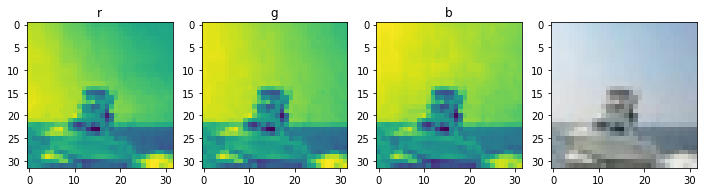

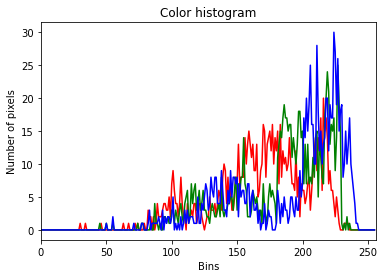

In [368]:
image_data = tf.keras.datasets.cifar10
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

colors=("r", "g", "b")

# this will read the image passed and return a 3-channel histogram of it
#path = r"test_images/lenna.png"
#path = r"test_images/rgb_test.png"
#path = r"test_images/rgb_test2.webp"
#img = cv2.imread(path) # stores images in BGR format
#img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image_index = 100
img = train_img[image_index] #choice(train_img)

chans=cv2.split(img)

_, axs = plt.subplots(1, 4, figsize=(12, 12))
plt.imshow(img)
axs = axs.flatten() # works but vscode marks as an error for some reason
i = 0
for img, ax in zip(chans, axs):
    ax.set_title(colors[i])
    ax.imshow(img)
    i += 1
plt.show()

plt.figure()
plt.title("Color histogram")
plt.xlabel("Bins")
plt.ylabel("Number of pixels")
for (chan, c) in zip(chans, colors):
    hist=cv2.calcHist([chan], [0], None, [256], [0,256])
    plt.plot(hist, color=c)
    plt.xlim([0,256])
plt.show()

First feature: color representations

In [388]:
# this will divide every image in the training set into their respective channels and store them

color_representations = [] # a tuple in the form (label, image, [channels])


print(f"Dividing {len(train_img)} images into channels...")
for i in range(len(train_img)):
    chans=cv2.split(train_img[i])
    color_representations.append((train_labels[i], train_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

Dividing 50000 images into channels...
0 images divided
10000 images divided
20000 images divided
30000 images divided
40000 images divided
50000 images divided, Done!


In [390]:

color_features = []
for i in range(len(color_representations)):
    image_colors = []
    for (channel, c) in zip(color_representations[i][2], colors):
        hist=cv2.calcHist([channel], [0], None, [256], [0,256])

        #list[i].extend(hist)
        image_colors.extend(hist)
        #image_colors.extend(hist)
        
    #list[i].extend(hist)
    color_features.append(image_colors)
color_features = np.squeeze(np.array(color_features))


0 images patched
10000 images patched
20000 images patched
30000 images patched
40000 images patched
50000 images patched, Done!


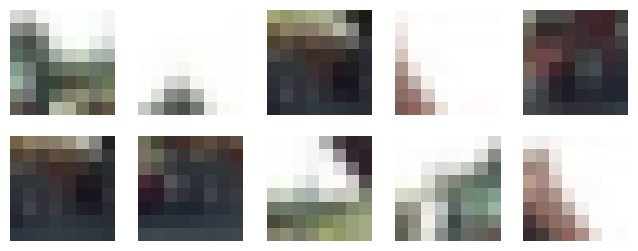

In [69]:
# returns a list of patches from the image passed
def get_patches(image, patch_size=8, n_patches=1000, random_state=10):
    patches = extract_patches_2d(image, patch_size=(patch_size, patch_size), max_patches=n_patches, random_state=10)
    return patches

# filling up the array with patches for each image
# also, both of these versions take the same amount of time to run :(

# version 1
patches_array = []
i = 0
for image in train_img:
    patches = get_patches(image)
    patches_array.append(patches)
    if i % 10000 == 0:
        print(f"{i} images patched")
    i += 1
print(f"{i} images patched, Done!")


# version 2
""" 
from joblib import Parallel, delayed
patches_array = Parallel(n_jobs=-1)(delayed(get_patches)(image) for image in train_img)
"""

# shows some of the patches
# the patches are taken from the image above
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(patches_array[image_index][i])
    plt.axis("off")


In [369]:
# now for the SIFT part
from PIL import Image

start = tf.timestamp() #take time of how long it takes to extract SIFT features
sift = cv2.SIFT_create()
orb = cv2.ORB_create(scaleFactor=1.0, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)

""" 
# returns a tuple of (image, keypoints, descriptors) after applying sift or orb to the image passed
def get_keypoints_descriptors(img):
    # for sift
    img = cv2.resize(img, (480, 480)) # interpolation=cv2.INTER_LINEAR
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    
    # for orb
    #keypoints, descriptors = orb.detectAndCompute(img, None)
    #img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

    return (img, keypoints, descriptors)
"""

sift_array = [] # a tuple in the form (image, keypoints, descriptors)
train_image_labels = []
for i in range(len(train_img)):
    img = train_img[i]

    # resizing takes too much time, so I'll leave it at 2x
    #img = img.resize((480, 480))
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST) # interpolation=cv2.INTER_LINEAR
    #img = cv2.resize(image, (0, 0), fx = 2, fy = 2, interpolation=cv2.INTER_NEAREST)

    # for sift
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    if descriptors is not None:
        sift_array.append((img, keypoints, descriptors)) #only add images for which keypoints and descriptors were found
        train_image_labels.append(train_labels[i]) #add label to list of labels of images used in training
    #sift_array.append(get_keypoints_descriptors(img))
    if i % 10000 == 0:
        print(f"{i} images described using sift")
    i += 1
print(f"{i} images described, Done!")
print('Feature extraction time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')
image_index = 50

# showing one example after training them all
img = sift_array[image_index][0]
""" img = train_img[image_index]
img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_LINEAR)
img = get_keypoints_descriptors(img)[0] """
cv2.imshow("Image", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


0 images described using sift
10000 images described using sift
20000 images described using sift
30000 images described using sift
40000 images described using sift
50000 images described, Done!
Feature extraction time:126.31028389930725 seconds


Bag of visual words representation of the SIFT features. There's some pictures for which no features were found, add an empty descriptor for those.

In [370]:
#a version where we exclude images with no features and also create the vstack from feature list
features = [] #array of feature descriptions

for i in range(len(sift_array)):
    features.append(sift_array[i][2])
features = np.vstack(features)


In [371]:
from sklearn.cluster import KMeans

n_clusters = 20 #20 clusters of features
kmeans = KMeans(n_clusters)
clustered = kmeans.fit_predict(features)

In [372]:

n_images = len(sift_array) #all the images we have features for
histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
old_count = 0 #current position in clustered
for i in range(n_images):
    l = len(sift_array[i][2]) #l is number of feature descriptors in image i
    for j in range(l):
        idx = clustered[old_count+j] #find those feature descriptors from clustered features
        histogram[i][idx] += 1 
    old_count += l #current position in clustered
    
       

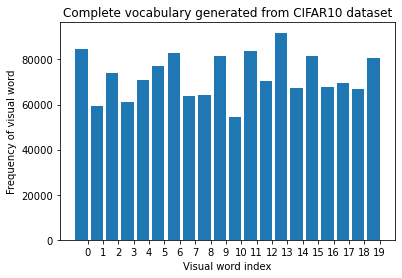

In [373]:
#visualize the vocabulary we have
x_scalar = np.arange(n_clusters)
y_scalar = np.array([abs(np.sum(histogram[:,h], dtype=np.int32)) for h in range(n_clusters)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual word index")
plt.ylabel("Frequency of visual word")
plt.title("Complete vocabulary generated from CIFAR10 dataset")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()


Standardize the histogram: after this the feature extraction is ready and we can train the shallow algorithms

In [374]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler().fit(histogram)
histogram = scale.transform(histogram)

Training part

In [246]:
from sklearn.svm import SVC
svm = SVC()
start = tf.timestamp()
svm.fit(histogram,train_image_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

c:\Users\noora\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time:237.02924394607544 seconds


Testing: SIFT features

In [381]:
sift_array_test = [] # a tuple in the form (image, keypoints, descriptors)
for i in range(len(test_img)):
    img = test_img[i]

    # resizing takes too much time, so I'll leave it at 2x
    #img = img.resize((480, 480))
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST) # interpolation=cv2.INTER_LINEAR
    #img = cv2.resize(image, (0, 0), fx = 2, fy = 2, interpolation=cv2.INTER_NEAREST)

    # sift features for the test images
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

    sift_array_test.append((img, keypoints, descriptors))
    #sift_array.append(get_keypoints_descriptors(img))

In [382]:
test_features = []

for i in range(len(sift_array_test)):
	if sift_array_test[i][2] is not None:
		test_features.append(sift_array_test[i][2]) #add feature descriptions

		
	else: #no features found for this image, add an empty descriptor because need to have correct dimensions for the stack
		print('No features found for image ' + str(i))
		test_features.append(np.zeros((1,sift.descriptorSize()),dtype=np.float32))
		
test_features = np.vstack(test_features)

No features found for image 3952


Group the features using kmeans

In [383]:
test_kmeans = kmeans.predict(test_features)

In [384]:

#create bag of words from test images
n_test_images = len(sift_array_test)
test_vocab = np.array([np.zeros(n_clusters) for i in range(n_test_images)])
old_count = 0
for i in range(n_test_images):
    if sift_array_test[i][2] is not None:
        l = len(sift_array_test[i][2]) #descriptor array of image i
        for j in range(l):
            idx = test_kmeans[old_count+j]
            test_vocab[i][idx] += 1
        old_count += l
    else:
        print('No features for this image') #no features were found so the vocabulary for this image will be empty

#scale using the scaler fit on training data
test_vocab = scale.transform(test_vocab)

No features for this image


In [251]:
start = tf.timestamp()
y_pred = svm.predict(test_vocab)
print('Testing time: '+ str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Testing time: 59.584917068481445 seconds


<AxesSubplot:title={'center':'CIFAR10 dataset, SIFT features, svm'}>

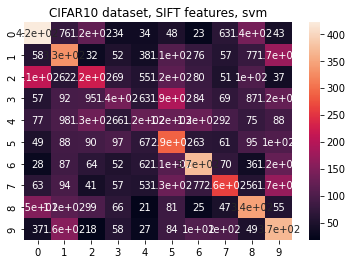

In [252]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusionmatrix = confusion_matrix(test_labels, y_pred)
plt.title('CIFAR10 dataset, SIFT features, svm')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)

In [253]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('SVM on SIFT features with default parameters:')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred)))
print('Precision: ' + str(precision_score(test_labels,y_pred,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred,average='macro')))

SVM on SIFT features with default parameters:
Accuracy: 0.2867
Precision: 0.28135540359193917
Recall: 0.2867


Classification using decision tree

In [376]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
start = tf.timestamp()
dt.fit(histogram, train_image_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:0.4481391906738281 seconds


In [385]:
start = tf.timestamp()
y_pred_bov_dt = dt.predict(test_vocab)
print('Testing time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Testing time:0.00542902946472168 seconds


<AxesSubplot:title={'center':'CIFAR10 dataset, SIFT features, decision tree'}>

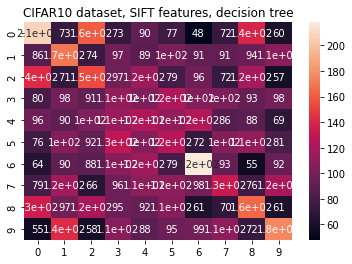

In [386]:
confusionmatrix = confusion_matrix(test_labels, y_pred_bov_dt)
plt.title('CIFAR10 dataset, SIFT features, decision tree')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)

In [387]:
print('Decision tree on SIFT features with default parameters:')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred_bov_dt)))
print('Precision: ' + str(precision_score(test_labels,y_pred_bov_dt,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred_bov_dt,average='macro')))

Decision tree on SIFT features with default parameters:
Accuracy: 0.158
Precision: 0.15821628349111655
Recall: 0.15799999999999997


# Colour histograms as features

In [391]:
from sklearn.svm import SVC
svm = SVC()
start = tf.timestamp()
svm.fit(color_features, train_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

c:\Users\noora\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time:2073.193773984909 seconds


In [392]:
color_representations_test = [] # a tuple in the form (label, image, [channels])


print(f"Dividing {len(test_img)} images into channels...")
for i in range(len(test_img)):
    chans=cv2.split(test_img[i])
    color_representations_test.append((test_labels[i], test_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

color_histograms_test = []
for i in range(len(color_representations_test)):
    image_colors = []
    for (channel, c) in zip(color_representations_test[i][2], colors):
        hist=cv2.calcHist([channel], [0], None, [256], [0,256])
        image_colors.extend(hist)
    color_histograms_test.append(image_colors)
color_histograms_test = np.squeeze(np.array(color_histograms_test))

Dividing 10000 images into channels...
0 images divided
10000 images divided, Done!


Testing time: 509.81580996513367 seconds
SVM on color histograms with default params
Accuracy: 0.3521
Precision: 0.3488167446273285
Recall: 0.35209999999999997


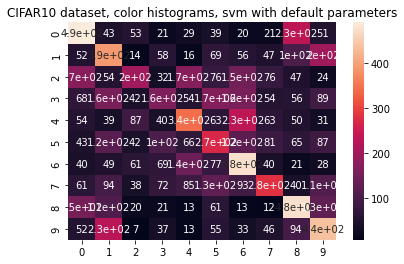

In [393]:
start = tf.timestamp()
y_pred = svm.predict(color_histograms_test)
print('Testing time: '+ str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')
confusionmatrix = confusion_matrix(test_labels, y_pred)
plt.title('CIFAR10 dataset, color histograms, svm with default parameters')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)
print('SVM on color histograms with default params')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred)))
print('Precision: ' + str(precision_score(test_labels,y_pred,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred,average='macro')))

Decision tree with color histogram

In [394]:
dt = DecisionTreeClassifier()
start = tf.timestamp()
dt.fit(color_features, train_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:29.30005979537964 seconds


In [396]:
start = tf.timestamp()
y_pred_dt = dt.predict(color_histograms_test)
print('Testing time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')


Testing time:0.03425908088684082 seconds


Decision tree trained on color histograms with default params
Accuracy: 0.1999
Precision: 0.2008821122451499
Recall: 0.19990000000000002


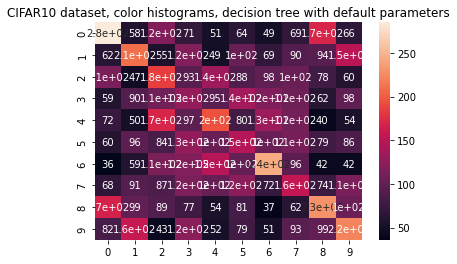

In [397]:
confusionmatrix = confusion_matrix(test_labels, y_pred_dt)
plt.title('CIFAR10 dataset, color histograms, decision tree with default parameters')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)
print('Decision tree trained on color histograms with default params')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred_dt)))
print('Precision: ' + str(precision_score(test_labels,y_pred_dt,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred_dt,average='macro')))